# (Probabilistic) Noise2Void

This notebook is a re-implementation of the code for denoising with [noise2void](https://openaccess.thecvf.com/content_CVPR_2019/html/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.html) as proovided by the authors in this [repository](https://github.com/juglab/pn2v). Unlike the original code, this implementation uses pytorch instead of tensorflow. The key idea is to crop small tiles from image data, replace a given pixel with any other pixel in the tile and then try to predict the true intensity of the replaced pixel. Since the intensity of every pixel $i$ consists of two components noise $n$ and $s$ (intensity $i=n+s$), the network will inevitably fail to predict the noise component $n$ of the pixel - thus cleaning up the image in the process.

## Source code

Since the torch-implementation of noise2void is currently not (yet) pip-installlable, we simply clone the repository and import the functions provided therein.

In [25]:
!git clone https://github.com/juglab/pn2v.git

fatal: destination path 'pn2v' already exists and is not an empty directory.


In [26]:
import os
os.chdir('pn2v')

In [34]:
import matplotlib.pyplot as plt
import numpy as np

from unet.model import UNet
from pn2v import utils
from pn2v import training, prediction
import pn2v.histNoiseModel
from skimage import io

device=utils.getDevice()

CUDA available? True


c:\Users\johan\Anaconda3\envs\pytorch\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataset

As a training dataset, we'll use [this data](https://zenodo.org/record/5837363) of a developing tribolium embryo.

In [37]:
root = '/projects/p038/p_scads_trainings/BIAS/torch_segmentation_denoising_example_data/denoising_example_data'
if os.path.exists(root):
    data = io.imread(os.path.join(root, 'lund_i000000_oi_000000.tif'))
else:
    url = r'https://zenodo.org/record/5837363/files/lund_i000000_oi_000000.tif' 
    data = io.imread(url)

## Training

We next create the model:

In [39]:
# The N2V network requires only a single output unit per pixel
net = UNet(1, depth=3)

Noise2void provides the `training.trainNetwork` function to run the training. The essential parameters here are the following:

- `numOfEpochs`: number of epochs to train
- `numOfIterations`: number of steps in each epochs
- `patchSize`: size of the patches to extract from the images
- `batchSize`: number of patches to use in each iteration

In [41]:
# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=data, valData=data,
                                           postfix='conv_N2V', directory=root, noiseModel=None,
                                           device=device, numOfEpochs=100, stepsPerEpoch=10, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3)

Epoch 0 finished      
avg. loss: 0.3001543402671814+-(2SEM)0.13842559616051073      
Epoch 1 finished      
avg. loss: 0.06297417059540748+-(2SEM)0.0077315374101247555      
Epoch 2 finished      
avg. loss: 0.04945159768685699+-(2SEM)0.005459553037417948      
Epoch 3 finished      
avg. loss: 0.04684696663171053+-(2SEM)0.006302806727339047      
Epoch 4 finished      
avg. loss: 0.05005248282104731+-(2SEM)0.0061245073012857944      
Epoch 5 finished      
avg. loss: 0.04483784632757306+-(2SEM)0.005787514311625785      
Epoch 6 finished      
avg. loss: 0.04111950676888228+-(2SEM)0.006151241561360584      
Epoch 7 finished      
avg. loss: 0.04324974250048399+-(2SEM)0.005570227374159575      
Epoch 8 finished      
avg. loss: 0.04368686466477811+-(2SEM)0.006323771290251492      
Epoch 9 finished      
avg. loss: 0.04553893078118563+-(2SEM)0.007333408527794197      
Epoch 10 finished      
avg. loss: 0.045366151910275224+-(2SEM)0.0073772458976522634      
Epoch 11 finished      
avg. 

In [10]:
n2vResult = prediction.tiledPredict(data[0], net ,ps=256, overlap=48,
                                        device=device, noiseModel=None)

Text(0.5, 1.0, 'Noise2Void result')

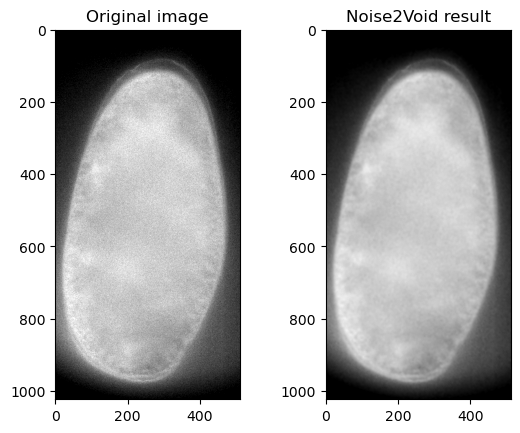

In [22]:
vmin = 150
vmax = 280

fig, axes = plt.subplots(ncols=2)

axes[0].imshow(data[0], cmap='gray', vmin=vmin, vmax=vmax)
axes[0].set_title('Original image')

axes[1].imshow(n2vResult, cmap='gray', vmin=vmin, vmax=vmax)
axes[1].set_title('Noise2Void result')

Text(0.5, 1.0, 'Noise2Void result')

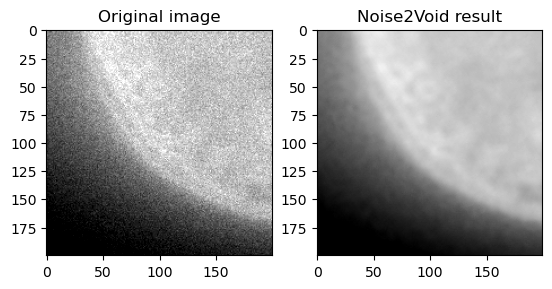

In [23]:
fig, axes = plt.subplots(ncols=2)

axes[0].imshow(data[0][800:1000, 0:200], cmap='gray', vmin=vmin, vmax=vmax)
axes[0].set_title('Original image')

axes[1].imshow(n2vResult[800:1000, 0:200], cmap='gray', vmin=vmin, vmax=vmax)
axes[1].set_title('Noise2Void result')